In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import numpy as np
#from mpl_toolkits.basemap import Basemap
from pandas import DataFrame
import math
import requests

from sklearn import cluster

from sklearn import preprocessing

import alphashape
from shapely.geometry import Polygon, Point, LineString

from sklearn import preprocessing

from descartes import PolygonPatch
import alphashape
import shapely

from sklearn.mixture import GaussianMixture
import matplotlib.patches as patches

import scipy.optimize as so
import os

import time

from sklearn.decomposition import PCA

import gurobipy as gp
from gurobipy import GRB

import warnings
warnings.filterwarnings('ignore') 

In [2]:
np.random.seed(123)

# X_orig = np.load("train_data_raw.npy")
# X_train = X_orig[:,0] ### temp error


########## regenerate the uncertainty set 
rng = np.random.default_rng(123)
X_train = np.random.rand()


# A = 3*(np.random.rand(10,10) - 0.5)
# B = 2.5*np.random.rand(10,10)
# C = np.random.rand(10,10)

mean_list = [np.array([-2]), np.array([-1])]
var_list = [np.array([[2]]), np.array([[1]])]

# mean_list = [-2*np.ones(10), -1*np.ones(10), -2*np.ones(10)]
# diag_list = [0.3*np.eye(10), 0.8*np.eye(10), 0.8*np.eye(10)]
size_list = [8000,300,3000]
# var_list = [A.T@diag_list[0]@A, B.T@diag_list[0]@B, C.T@diag_list[0]@C]


train_data = []

data_gaussian = np.array([[0]])
#data_gaussian = np.zeros(10).reshape(-1,10)
for i in range(1):#range(len(mean_list)):
    _data = rng.multivariate_normal(mean_list[i], var_list[i], size = size_list[i])
    data_gaussian = np.concatenate((data_gaussian, _data), axis = 0)
    
noise = rng.uniform(-8,5,500)

data_gaussian = np.append(data_gaussian, noise)

X_train = data_gaussian[1:].reshape(-1)
print(X_train.shape)


########### shuffle every 5 samples ##########
np.random.shuffle(X_train)
hori_len = 10
X_train = X_train[:int(len(X_train)/hori_len)*hori_len].reshape(-1,hori_len)
#np.random.shuffle(X_train)
train_size = int(len(X_train)*0.8)
X_scaled = X_train[:train_size]#.reshape(-1,5)
w_simu = X_train[train_size:].reshape(-1)


########### shuffle every samples ###########
#X_train = X_train[:int(len(X_train)/5)*5].reshape(-1,5)
# np.random.shuffle(X_train)
# train_size = int(len(X_train)*0.8/5)*5
# X_scaled = X_train[:train_size].reshape(-1,5)
# w_simu = X_train[train_size:]

def uncertain_set_construct(X, eps, min_samples, k_cluster, plot_fig = False):
    db = cluster.DBSCAN(eps = eps, min_samples = min_samples).fit(X)
    X_clean = X[db.labels_ != -1,:]
    
    outliers = X[db.labels_ == -1,:]
    
    gmm = GaussianMixture(n_components = k_cluster, covariance_type = "full", n_init = 50, random_state = 123)
    gmm.fit(X_clean)

    if plot_fig:
        plt.figure(figsize = (6,6))
        plt.scatter(X[db.labels_ == -1, 0], X[db.labels_ == -1, 1], 1, c = "k")
        
        plt.scatter(X_clean[:,0],X_clean[:,1], s = 0.1, c = gmm.fit_predict(X_clean), cmap = plt.cm.winter)
        ax = plt.gca()
        ax.set(aspect = "equal",xlim = [-1.5,1.5],ylim = [-1.5,1.5])
    print("outliers is {0:02f}% percent".format((len(outliers)/len(X))*100))
    
    return gmm, X_clean, outliers

(8500,)


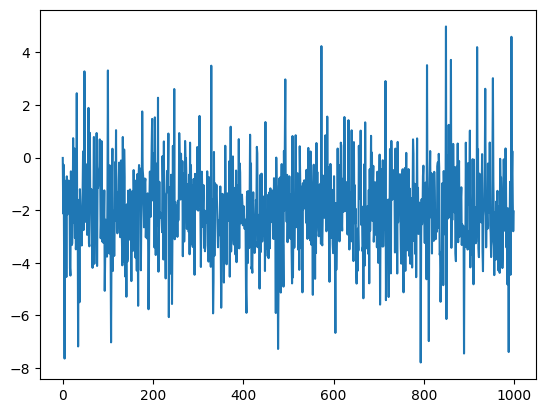

In [3]:
plt.plot(X_train.reshape(-1)[:1000])

In [4]:
np.min(X_train[:,8])

-7.63593216869412

In [79]:
# import os
# os.environ["OMP_NUM_THREADS"] = '3'
#eps_value = 3.29
eps_value = 4.33
gmm, X_clean, outliers = uncertain_set_construct(X_scaled, eps = eps_value, min_samples = (hori_len+1), k_cluster = 3, plot_fig = False)

outliers is 10.000000% percent


In [80]:
def generate_D_d(X_list):
    D_set = []
    d_set = []
    for i, X in enumerate(X_list):
    
        # if len(X) == 0:
        #     continue
            
        X_mean = np.mean(X, axis = 0)
        X_centered = X - X_mean  ### generate centered data ###
        
        pca = PCA(n_components = X.shape[1]).fit(X_centered)
        
        X_pca = pca.fit_transform(X_centered)
        
        pca_min = np.min(X_pca,axis = 0)#.reshape(-1,1)
        pca_max = np.max(X_pca,axis = 0)#.reshape(-1,1)
        
    
        P = pca.components_.T
    
        D_set.append(np.kron(np.array([[1],[-1]]), P.T))
        d_set.append(np.concatenate((pca_max+P.T@X_mean, -pca_min - P.T@X_mean)))

    return D_set, d_set    


def check_coverage(D_list, d_list, points):
    inside_num = 0
    vio_max = 1e-8
    for _, point in enumerate(points):
#        vio = 1e-3
        
        vio_list = []
        for k in range(len(D_list)):
            assert np.array(D_list[k]@point - d_list[k]).shape == (2*hori_len,)
            
            _vio = np.max(D_list[k]@point - d_list[k])
            vio_list.append(_vio)
           #  vio_max = np.maximum(vio_max, _vio)
           # # print(_vio)
           #  vio = np.minimum(vio, _vio)
        vio = min(vio_list)

       # print(vio)
        if vio <= vio_max:
            inside_num += 1
    print("vio_max is: ", vio_max)
    print("training data coverage is: ", inside_num/(points.shape[0]))
    return inside_num/(len(points))

outliers is 10.000000% percent
vio_max is:  1e-08
training data coverage is:  0.9264705882352942
outliers is 10.000000% percent
vio_max is:  1e-08
training data coverage is:  0.9264705882352942
outliers is 10.000000% percent
vio_max is:  1e-08
training data coverage is:  0.9161764705882353
outliers is 10.000000% percent
vio_max is:  1e-08
training data coverage is:  0.913235294117647
outliers is 10.000000% percent
vio_max is:  1e-08
training data coverage is:  0.9102941176470588
outliers is 10.000000% percent
vio_max is:  1e-08
training data coverage is:  0.9014705882352941


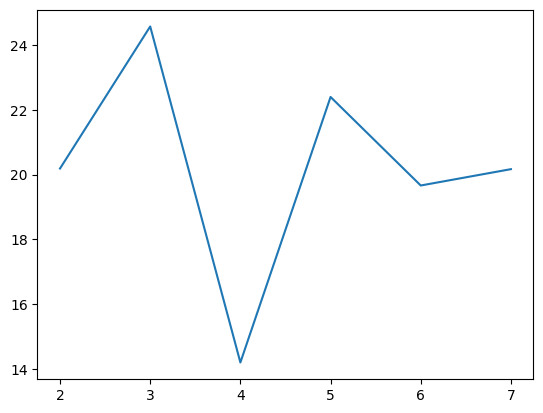

In [81]:
################ preprocessing the data ##################
from sklearn.metrics import silhouette_score, calinski_harabasz_score
cluster_list = range(2, 8)
ss_list = []
ch_list = []
covreg_list = []
for n_clusters in cluster_list:

    gmm, X_clean, outliers = uncertain_set_construct(X_scaled, eps = eps_value, min_samples = (hori_len+1), k_cluster = n_clusters, plot_fig = False)
    cls_labels = gmm.predict(X_clean)
    ss = silhouette_score(X_clean, cls_labels)
    ch = calinski_harabasz_score(X_clean, cls_labels)
    ss_list.append(ss)
    ch_list.append(ch)

    X_list = []
    for i in range(n_clusters):
        X_list.append(X_clean[ cls_labels == i,:])
        
    D_set, d_set = generate_D_d(X_list)
    covreg_list.append(check_coverage(D_set, d_set, X_scaled))
    
# plt.figure(figsize = (4,2.5))
# plt.scatter(cluster_list, ss_list)
# plt.xlabel("$K$")
# plt.ylabel("silhouette score")
# plt.savefig("ss.pdf", bbox_inches = "tight")

# plt.figure()
# plt.plot(cluster_list, covreg_list)
plt.plot(cluster_list, ch_list)

[(0.9, 1.0)]

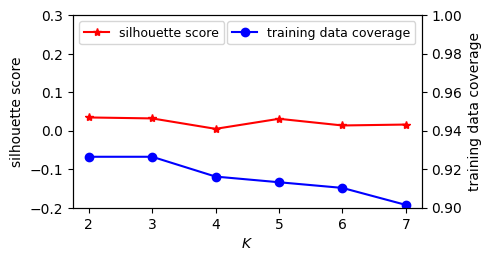

In [82]:
fig, ax1 = plt.subplots(figsize = (4.5,2.5))
ax1.plot(cluster_list, ss_list,"-*", color = "r", label = "silhouette score")
ax1.set_ylabel("silhouette score")
ax1.set_xlabel("$K$")
ax1.legend(loc = 2, fontsize = 9)
ax1.set(ylim = [-0.2,0.3])

ax2 = ax1.twinx()
ax2.plot(cluster_list, covreg_list, "-o", color = "b", label = "training data coverage")
ax2.set_ylabel("training data coverage")
ax2.legend(loc = 1, fontsize = 9)
ax2.set(ylim = [0.90, 1])
#plt.savefig("ss.pdf", bbox_inches = "tight")
#plt.legend([ax1, ax2], ["ss", "cov"])

In [ ]:
covreg_list

In [83]:
######################### select the final cluster size 
n_clusters = 4
gmm, X_clean, outliers = uncertain_set_construct(X_scaled, eps = eps_value, min_samples = (hori_len+1), k_cluster = n_clusters, plot_fig = False)
cls_labels = gmm.predict(X_clean)

X_list = []
for i in range(n_clusters):
    X_list.append(X_clean[ cls_labels == i,:])

outliers is 10.000000% percent


In [84]:
def comput_sqrtM(C_mat):
    v, P = np.linalg.eig(C_mat)
    Q = P@np.diag(v**(-0.5))@np.linalg.inv(P)
    return Q


def generate_ellipsoid(gmm, X_clean):
    cls_labels = gmm.predict(X_clean)
    beta_list = []
    SigmaInv2_list = []
    varrho_list = []
    for i in range(n_clusters):
        X = X_clean[cls_labels == i, :]
        X_mean = gmm.means_[i,:]
        Sigma = gmm.covariances_[i]
        Sigma_inv2 =  comput_sqrtM(Sigma) #np.linalg.inv(Sigma)
        varrho = np.max(np.array([np.linalg.norm(Sigma_inv2@(X[t,:] - X_mean), 2) for t in range(X.shape[0])]))

        beta_list.append(X_mean)
        SigmaInv2_list.append(Sigma_inv2)
        varrho_list.append(varrho)

    np.savez("ellipsoid.npz", beta_list = beta_list, SigmaInv2_list = SigmaInv2_list, varrho_list = varrho_list)

generate_ellipsoid(gmm, X_clean)

In [85]:
def check_coverage_ellip(beta_list, SigmaInv2_list, varrho_list, points):
    inside_num = 0
    for _, point in enumerate(points):
#        vio = 1e-3
        vio_max = 1e-8
        vio_list = []
        for k in range(len(beta_list)):
            #assert np.array(D_list[k]@point - d_list[k]).shape == (10,)
            
            _vio = np.linalg.norm(SigmaInv2_list[k]@(point - beta_list[k]), 2) - varrho_list[k]
            vio_list.append(_vio)
           #  vio_max = np.maximum(vio_max, _vio)
           # # print(_vio)
           #  vio = np.minimum(vio, _vio)
        vio = min(vio_list)

       # print(vio)
        if vio <= vio_max:
            inside_num += 1
    print("vio_max is: ", vio_max)
    print("training data coverage of ellipsoid is: ", inside_num/(len(points)))
    return inside_num/(len(points))

In [86]:
uncer_sets_ellip = np.load(r"ellipsoid.npz")
beta_list, SigmaInv2_list, varrho_list = uncer_sets_ellip["beta_list"], uncer_sets_ellip["SigmaInv2_list"],uncer_sets_ellip["varrho_list"]

check_coverage_ellip(beta_list, SigmaInv2_list, varrho_list, X_scaled)

vio_max is:  1e-08
training data coverage of ellipsoid is:  0.9117647058823529


0.9117647058823529

In [13]:
# for i in range(len(beta_list)):
#     print("average value is:", beta_list[i])
#     eig_value, _ = np.linalg.eig(SigmaInv2_list[i])
#     print("eigen value is: ", eig_value)
#     print("bound value is: ", varrho_list[i])

In [14]:
#########################################
#####     closed-loop computation     #####
#########################################


# ellipsoid = np.load("ellipsoid.npz")
# beta_list = ellipsoid["beta_list"]
# SigmaInv2_list = ellipsoid["SigmaInv2_list"]
# varrho_list = ellipsoid["varrho_list"]

# import gurobipy as gp
# from gurobipy import GRB
# ##### indoor temp constraints
# day = 100
# T_low_base = np.array([15,15,15,15,15,15,15,21,21,21,21,21,21,21,21,21,21,21,15,15,15,15,15,15])
# T_low = np.array([T_low_base for _ in range(day)])
# T_low = T_low.reshape(-1)

# Gx = np.kron(-np.eye(N), np.array([[1,0,0,0]]))

# # Gx = np.kron(np.array([[1],[-1]]), np.kron(np.eye(N),np.array([[1,0,0,0]])))

# #T_high = 24*np.ones(24*day) 
# # gx = np.kron(np.array([T_high, -T_low]), np.ones(N))

# ##### total input constraints
# Gu = np.kron(np.array([[1],[-1]]), np.eye(N))

# U_high = 150*np.ones(N)### total maximal power input
# gu = np.concatenate((U_high*np.ones(N), np.zeros(N)))


# ####################### temperature constraints #######################
# W1 = Gx@Fu
# M1 = Gx@Fw  ### w_vec: vector of disturbance

# ####################### physical constraints of HP ######################
# W2 = Gu
# M2 = np.zeros(shape = (2*N, N))
# h2 = gu ### gu is the vector constructed from the upper and lower bounds of total inputs

# W = np.concatenate((W1,W2), axis = 0)
# M = np.concatenate((M1,M2), axis = 0)


# b = np.ones(N)

# N_sim = 24*60
# T_ground = np.mean(T_out)


# svc_params = np.load(r"svc_param.npz")
# sv_points = svc_params["sv_data"]
# sv_alpha = svc_params["sv_alpha"]
# sv_theta = svc_params["theta"]


# name_list = ["ellip"]#, "box", "kde", "bdgp", "ksvc"]
# x_vec_list = []
# for name in name_list:    
#     x0 = np.array([22,22,22,22])
#     x_vec = x0.copy()
#     cost = 0

#     time_start = time.time()
#     for t in range(N_sim):
    
#         v1_vec = T_out[t:t+N]
#         v2_vec = T_ground * np.ones(N)
        
#         w = np.array([w_simu[t]])
#         v = np.array([v1_vec[0], v2_vec[0]])
         
#         Fx0 = Fx@x0
    
#         #gx = np.concatenate((T_high[t:t+N],-T_low[t:t+N]))
#         gx = -T_low[t:t+N]
#         h1 = gx - Gx@(Fv1@v1_vec + Fv2@v2_vec + Fx0) ### gx is the upper and lower bounds of indoor temperature

#         h = np.concatenate((h1,h2))
        
#         u, _L, _g = RMPC_ellip(beta_list, SigmaInv2_list, varrho_list, W, M, h, b)

#         cost += u
#         x = A@x0 + Bu@u + Bw@w + Bv@v
#         x0 = x
#         x_vec = np.concatenate((x_vec, x), axis = 0)
        
#     time_end = time.time()
#     x_vec_list.append(x_vec.reshape(-1,4))

#     plt.plot(x_vec.reshape(-1,4)[1:,0])
#     plt.legend(name_list)

#     vio, vio_per = comp_violation(x_vec.reshape(-1,4)[1:,0], T_low[:N_sim])

#     print("the violation of "+ name + " is: ", vio, vio_per)
#     print("total cost of " + name + " is: ", cost)
#     print("average cost of " + name + "is ", cost/N_sim)
#     print("the average computation time is: ", (time_end - time_start)/N_sim)
    
    
# T_low = np.concatenate((np.array([15]), T_low), axis = 0)

In [15]:
# plt.figure(figsize = (10,3))
# xlabel1 = list(range(24*31))
# plt.plot(xlabel1, x_vec_list[0][:,0][:24*31], "--", linewidth = 1.2, color = "r")
# plt.plot(xlabel1, x_vec_list[1][:,0][:24*31], linestyle = "dotted", linewidth = 1.5, color = "g")
# plt.plot(xlabel1, x_vec_list[2][:,0][:24*31], linewidth = 1, color = "b")
# plt.plot(xlabel1, x_vec_list[3][:,0][:24*31], "-.", linewidth = 1.2, color = "orange")
# plt.plot(xlabel1, T_low[:24*31],"-.", linewidth = 1, color = "cyan")

# plt.legend(["Box", "KDE", "B-DPG", "K-SVC", "Constraint"], ncols = 5, loc = 1)
# plt.axis((0,750,14,28))
# plt.xlabel("time (h)")
# plt.ylabel("temperature ($^\circ$C)")

In [87]:
################# generate uncertainty sets for B-DGP approach ###################

D_set = []
d_set = []

# n_components = 5  ### pca components

for i, X in enumerate(X_list):
    
    if len(X) == 0:
        continue
        
    X_mean = np.mean(X, axis = 0)
    X_centered = X - X_mean  ### generate centered data ###
    
    pca = PCA(n_components = hori_len).fit(X_centered)
    
    X_pca = pca.fit_transform(X_centered)
    
    pca_min = np.min(X_pca,axis = 0)#.reshape(-1,1)
    pca_max = np.max(X_pca,axis = 0)#.reshape(-1,1)
    

    P = pca.components_.T

    D_set.append(np.kron(np.array([[1],[-1]]), P.T))
    d_set.append(np.concatenate((pca_max+P.T@X_mean, -pca_min - P.T@X_mean)))

array_dict = {"D_set": D_set, "d_set": d_set}
np.savez("uncer_set.npz", **array_dict)

In [88]:
####################################### 存储生成的uncertainty set ##########################################
uncer_sets = np.load(r"uncer_set.npz")
D_set = uncer_sets["D_set"]
d_set = uncer_sets["d_set"]

In [89]:
X_scaled.shape

(680, 10)

In [90]:
print("coverage of B-DGP is ", check_coverage(D_set, d_set, X_scaled))

vio_max is:  1e-08
training data coverage is:  0.9161764705882353
coverage of B-DGP is  0.9161764705882353


In [91]:
####### kernel-based support vector machine ##########
svm_start = time.time()

X_train_svc = X_scaled
N = len(X_train_svc)
C_mat = np.cov(X_train_svc.T)#(X_train.T@X_train - np.sum(X_train, axis = 0).reshape(-1,1).T@np.sum(X_train, axis = 0).reshape(1,-1))/(N-1)

v, P = np.linalg.eig(C_mat)
Q = P@np.diag(v**(-0.5))@np.linalg.inv(P)

def Kernel(w,v): #### define kernel function
    L = 5000
    ### C is the covariance matrix
    return L - np.linalg.norm(Q@(w - v), ord = 1) 

Ker_mat = np.eye(N)
for i in range(N):
    for j in range(N):
        Ker_mat[i,j] = Kernel(X_train_svc[i,:],X_train_svc[j,:])
        


nu = 0.1 ## to preclude 10% outliers


m = gp.Model("K_SVM")
alpha = m.addMVar(shape = N, vtype = GRB.CONTINUOUS, lb = 0.0, ub = 1/(N*nu))
m.addConstr(sum(alpha) == 1)

# Obj = gp.QuadExpr()
# Obj += (sum( sum(alpha[i]*alpha[j]*Ker_mat[i,j] for j in range(N)) for i in range(N) ) -
#     sum(alpha[i]*Ker_mat[i,i] for i in range(N)))

Obj_new = gp.QuadExpr()
Obj_new += alpha@(Ker_mat@alpha) - alpha@np.diag(Ker_mat)

m.setObjective(Obj_new, GRB.MINIMIZE)

#m.Params.MIPGapAbs = 1e-3
m.setParam("OutputFlag", 0)
m.optimize()
svm_end = time.time()

print("computation time of svm is: ", svm_end - svm_start)

computation time of svm is:  6.242681264877319


In [92]:
ksvm_accuracy = 1e-8
SV_idx = (ksvm_accuracy < alpha.X)
BSV_idx = (0 + ksvm_accuracy < alpha.X) & (alpha.X < (1/(N*nu) - ksvm_accuracy) )
Out_idx = alpha.X >= (1/(N*nu) - ksvm_accuracy)
Iner_idx = alpha.X <= ksvm_accuracy
print("total portion of support vectors is: ", sum(SV_idx)/len(SV_idx))
print("total portion of boundary support vectors is: ", sum(BSV_idx)/len(SV_idx))
print("total portion of outliers is: ", sum(Out_idx)/len(Out_idx))
print("total portion of interiors is: ", sum(Iner_idx)/len(Iner_idx))


multi_alpha = alpha.x[SV_idx]
SV_data = X_train_svc[SV_idx,:]
BSV_data = X_train_svc[BSV_idx,:]
Out_data = X_train_svc[Out_idx,:]
Iner_data = X_train_svc[Iner_idx,:]

print("the number of support vectors are: ", sum(SV_idx))

theta = np.max([sum( multi_alpha[i]*np.linalg.norm(Q@(BSV_data[j] - SV_data[i]), ord = 1) for i in range(len(SV_data)) ) for j in range(len(BSV_data))])


x_out = 0
for t in range(len(X_train_svc)):
    if sum( multi_alpha[k]*np.linalg.norm(Q@(X_train_svc[t] - SV_data[k]), 1) for k in range(len(SV_data)) ) <= theta:
        x_out += 1
print("the percentage of outlier is: ", 1 - x_out/len(X_train_svc))


sv_dict = {"sv_data": SV_data, "sv_alpha": multi_alpha, "theta": theta}

np.savez("svc_param.npz", **sv_dict)


total portion of support vectors is:  0.11323529411764706
total portion of boundary support vectors is:  0.033823529411764704
total portion of outliers is:  0.07941176470588235
total portion of interiors is:  0.8867647058823529
the number of support vectors are:  77
the percentage of outlier is:  0.07499999999999996


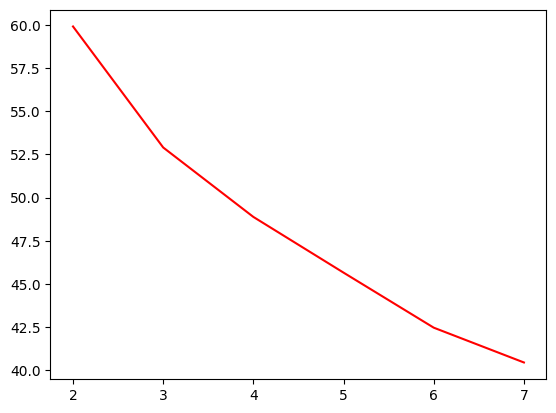

In [93]:
################ preprocessing the data ##################
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans

cluster_list = range(2, 8)
ss_list = []
ch_list = []
covreg_list = []
for n_clusters in cluster_list:

    kmeans = KMeans(n_clusters = n_clusters, n_init = 50).fit(X_scaled)

#    gmm, X_clean, outliers = uncertain_set_construct(X_scaled, eps = 1.21, min_samples = 6, k_cluster = n_clusters, plot_fig = False)
    ss = silhouette_score(X_scaled, kmeans.labels_)
    ch = calinski_harabasz_score(X_scaled, kmeans.labels_)
    ss_list.append(ss)
    ch_list.append(ch)

plt.plot(cluster_list, ch_list, "r")
#plt.plot(cluster_list, ch_list, "b")
    # X_list = []
    # for i in range(n_clusters):
    #     X_list.append(X_clean[ cls_labels == i,:])
        
    # D_set, d_set = generate_D_d(X_list)
    # covreg_list.append(check_coverage(D_set, d_set, X_scaled))

confi_level is:  0.0052403708968927765


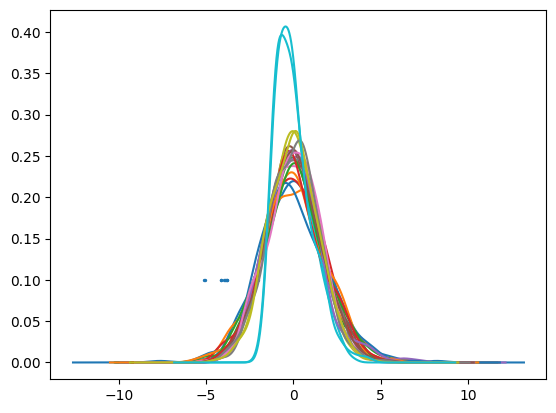

In [94]:
###### generate uncertainty sets for box #####
D_box = np.kron(np.array([[1], [-1]]), np.eye(X_scaled.shape[1]))
d_box = np.array([])

for i in range(X_scaled.shape[1]):
    d_max  = np.max(X_scaled, axis = 0)
    d_min = np.min(X_scaled, axis = 0)
    d_box = np.concatenate((d_max, -d_min))

D_box_set = [D_box]
d_box_set = [d_box]


###############################################
###### generate uncertainty sets for KDE ######
###############################################


confi_percent = 0.9 ###
confi_level = (1 - pow(confi_percent,1/hori_len))/2
print("confi_level is: ", confi_level)


n_clusters = 2
kmeans = KMeans(n_clusters = n_clusters, n_init = 100).fit(X_scaled)

X_kmeans_list = []
for i in range(n_clusters):
    X_kmeans_list.append(X_scaled[kmeans.labels_ == i,:])


D_kde_set = []
d_kde_set = []

kde_pca_min = np.array([])
kde_pca_max = np.array([])
for k, X_kmeans in enumerate(X_kmeans_list):
    
    X_kde_mean = np.mean(X_kmeans, axis = 0)
    X_centered_kde = X_kmeans - X_kde_mean
    
    n_components = hori_len
    pca_kde = PCA(n_components = n_components).fit(X_centered_kde)
    
    X_pca_kde = pca_kde.fit_transform(X_centered_kde)
    
    
    
    kde_pca_minmax = np.array([])
    for i in range(X_pca_kde.shape[1]):
    
        data = X_pca_kde[:,i]
        kde = gaussian_kde(data)
        
        data_min = np.min(data, axis = 0) - 5
        data_max = np.max(data, axis = 0) + 5
    
        x_values = np.linspace(data_min, data_max, 10000)
        
        # Calculate PDF using the KDE object
        pdf_values = kde.pdf(x_values)
        
        # Calculate CDF by taking cumulative sum of PDF values
        cdf_values = np.cumsum(pdf_values)*((data_max - data_min)/len(x_values))
    
        min_max = np.array([np.min(x_values[cdf_values>= confi_level]), np.min(x_values[cdf_values >=1 - confi_level])])
        kde_pca_minmax = np.append(kde_pca_minmax, min_max, axis = 0)

        plt.plot(x_values, pdf_values)
    
    kde_pca_minmax = kde_pca_minmax.reshape(-1,2)
    pca_kde_min = kde_pca_minmax[:,0]
    pca_kde_max = kde_pca_minmax[:,1]
    P_kde = pca_kde.components_.T
    
    D_kde = np.kron(np.array([[1],[-1]]), P_kde.T)
    d_kde = np.concatenate( (P_kde.T@X_kde_mean + pca_kde_max, -P_kde.T@X_kde_mean - pca_kde_min) )
    
    D_kde_set.append(D_kde)
    d_kde_set.append(d_kde)

# plt.figure()
# plt.plot(x_values, pdf_values) 
plt.scatter(pca_kde_min, 0.1*np.ones(len(pca_kde_min)), s= 2)

In [95]:
print("coverage of KPKDE is ", check_coverage(D_kde_set, d_kde_set, X_scaled))

vio_max is:  1e-08
training data coverage is:  0.9455882352941176
coverage of KPKDE is  0.9455882352941176


In [96]:
print("coverage of Box is ", check_coverage(D_box_set, d_box_set, X_scaled))

vio_max is:  1e-08
training data coverage is:  1.0
coverage of Box is  1.0


In [97]:
#############
### robust MPC with ellipsoid uncertainty set
#############

def RMPC_ellip(beta_list, SigmaInv2_list, varrho_list, W, M, h, b, multi_rules = True):
    m = gp.Model("ellip")
    eta = m.addVar(vtype = GRB.CONTINUOUS)

    bigM = 1e5

    y_len = W.shape[1] 
    u_len = M.shape[1] 
    I = W.shape[0]

    ind_u = range(u_len)
    
    K= len(beta_list)

    if multi_rules == False:
        K = 1

    epsilon = m.addMVar(shape = (I,), vtype = GRB.CONTINUOUS, lb = 0)
    
    L = m.addMVar(shape = (y_len, u_len, K), lb = -float("inf"), vtype = GRB.CONTINUOUS)
    g = m.addMVar(shape = (y_len, K), lb = -float("inf"), vtype = GRB.CONTINUOUS)

    m.addConstrs((g[0,0] == g[0,k] for k in range(K)))

    Xi0 = m.addMVar(shape = (K, u_len), lb = -float("inf"), vtype = GRB.CONTINUOUS)
    Pi0 = m.addMVar(shape = (K, ), lb = 0, vtype = GRB.CONTINUOUS)

    Xi = m.addMVar(shape = (K, I, u_len), lb = -float("inf"), vtype = GRB.CONTINUOUS)
    Pi = m.addMVar(shape = (K, I), lb = 0, vtype = GRB.CONTINUOUS)

    for k in range(K):
        for i in range(y_len):
            for j in range(u_len):
                if i <= j:
                    m.addConstr(L[i,j,k] == 0)

    for k in range(K):
        m.addConstrs((b@L[:,j,k] == Xi0[k,:]@SigmaInv2_list[k][:,j] for j in range(u_len)))
        m.addConstr(eta - b@(L[:,:,k]@beta_list[k]) - b@g[:,k] == Pi0[k])
        m.addConstr( (varrho_list[k]**2) * (Xi0[k,:]@Xi0[k,:]) <= Pi0[k]**2 )

        for i in range(I):
            m.addConstrs( (W[i,:]@L[:,j,k] + M[i,j] == Xi[k,i,:]@SigmaInv2_list[k][:,j] for j in range(u_len)) )
            m.addConstr( (h[i] + epsilon[i] - (W[i,:]@L[:,:,k] + M[i,:])@beta_list[k] - W[i,:]@g[:,k] == Pi[k,i] ) )
            m.addConstr( ((varrho_list[k]**2) * Xi[k,i,:]@Xi[k,i,:] <= Pi[k,i]**2 ) )

    m.setObjective(eta + bigM*sum(epsilon), GRB.MINIMIZE)
    m.setParam("OutputFlag", 0)  
    m.setParam('Timelimit', 300)
    m.optimize()

    return np.array([g.x[0,0]]), L.x, g.x 

In [67]:
def LDR_RO(D_set, d_set, W1, M1, h1, W2, M2, h2, b):
    m = gp.Model("LDR")
    eta = m.addVar(vtype = GRB.CONTINUOUS)

    bigM = 1e5

    y_len = W1.shape[1] 
    u_len = M1.shape[1] 
    I1 = W1.shape[0]
    I2 = W2.shape[0]
    I = int(I1+I2)

    W = np.concatenate((W1,W2), axis = 0)
    M = np.concatenate((M1,M2), axis = 0)

    ind_u = range(u_len)
    K= len(D_set)
    D_len = D_set[0].shape[0]  ### the number of rows for uncertainty set constraints

    epsilon = m.addMVar(shape = (I1,), vtype = GRB.CONTINUOUS, lb = 0)
    
    L = m.addMVar(shape = (y_len,u_len,K), vtype = GRB.CONTINUOUS, lb = -float("inf"),)
    g = m.addMVar(shape = (y_len,K), vtype = GRB.CONTINUOUS, lb = -float("inf"),)
    xi = m.addMVar(shape = (I+1,D_len,K), vtype = GRB.CONTINUOUS, lb = 0) # shape of Xi is (I, D_len, K)

    m.addConstrs((g[0,0] == g[0,k] for k in range(K)))

    for k in range(K):
        for i in range(y_len):
            for j in range(u_len):
                if i <= j:
                    m.addConstr(L[i,j,k] == 0)

    for k in range(K):
        m.addConstr(b@g[:,k] + xi[0,:,k]@d_set[k] <= eta)
        m.addConstr(D_set[k].T@xi[0,:,k] == L[:,:,k].T@b) 
        
        m.addConstrs(d_set[k]@xi[i+1,:,k] + W1[i,:]@g[:,k] <= h1[i] + epsilon[i] for i in range(I1))
        m.addConstrs(d_set[k]@xi[i+I1+1,:,k] + W2[i,:]@g[:,k] <= h2[i] for i in range(I2))
        
        m.addConstrs(D_set[k].T[j]@xi[i+1,:,k] == W[i,:]@L[:,j,k] + M[i,j] for j in ind_u for i in range(I) )

    m.setObjective(eta + bigM*sum(epsilon), GRB.MINIMIZE)
    m.setParam("OutputFlag", 0)   
    m.optimize()

    return np.array([g.x[0,0]]), L.x, g.x 

In [68]:
def LDR_RO_oneshot(D_set, d_set, W1, M1, h1, W2, M2, h2, b, multi_rules = True):
    m = gp.Model("LDR")
    eta = m.addVar(vtype = GRB.CONTINUOUS)

    bigM = 1e5

    y_len = W1.shape[1] 
    u_len = M1.shape[1] 
    I1 = W1.shape[0]
    I2 = W2.shape[0]
    I = int(I1+I2)

    W = np.concatenate((W1,W2), axis = 0)
    M = np.concatenate((M1,M2), axis = 0)

    ind_u = range(u_len)
    K= len(D_set)
    if multi_rules == False:
        K = 1
    D_len = D_set[0].shape[0]  ### the number of rows for uncertainty set constraints

    epsilon = m.addMVar(shape = (I1,), vtype = GRB.CONTINUOUS, lb = 0)
    
    L = m.addMVar(shape = (y_len,u_len,K), vtype = GRB.CONTINUOUS, lb = -float("inf"))
    g = m.addMVar(shape = (y_len,K), vtype = GRB.CONTINUOUS, lb = -float("inf"))
    xi = m.addMVar(shape = (I+1,D_len,K), vtype = GRB.CONTINUOUS, lb = 0) # shape of Xi is (I, D_len, K)

    m.addConstrs((g[0,0] == g[0,k] for k in range(K)))

    for k in range(K):
        for i in range(y_len):
            for j in range(u_len):
                if i <= j:
                    m.addConstr(L[i,j,k] == 0)

    for k in range(K):
        m.addConstr(b@g[:,k] + xi[0,:,k]@d_set[k] <= eta)
        m.addConstr(D_set[k].T@xi[0,:,k] == L[:,:,k].T@b) 
        
        m.addConstrs(d_set[k]@xi[i+1,:,k] + W1[i,:]@g[:,k] <= h1[i] + epsilon[i] for i in range(I1))
        m.addConstrs(d_set[k]@xi[i+I1+1,:,k] + W2[i,:]@g[:,k] <= h2[i] for i in range(I2))
        
        m.addConstrs(D_set[k].T[j]@xi[i+1,:,k] == W[i,:]@L[:,j,k] + M[i,j] for j in ind_u for i in range(I) )

    m.setObjective(eta + bigM*sum(epsilon), GRB.MINIMIZE)
    m.setParam("OutputFlag", 0)   
    m.optimize()

    return np.array([g.x[0,0]]), L.x, g.x 

In [69]:
def MPC_ksvc(sv_points, sv_alpha, theta, W, M, h, b):
    sv_len = sv_points.shape[0]
    sv_dim = sv_points.shape[1]
    sv_idx = range(sv_len)
    
    I = W.shape[0]

    y_len = W1.shape[1] 
    u_len = M1.shape[1] 
    bigM = 1e5
    
    m = gp.Model("svc")
    beta = m.addVar(vtype = GRB.CONTINUOUS)
    epsilon = m.addMVar(shape = (I, ), vtype = GRB.CONTINUOUS, lb = 0)
    
    mu = m.addMVar(shape = (sv_len, sv_dim, I+1), vtype = GRB.CONTINUOUS, lb = 0)
    lamda = m.addMVar(shape = (sv_len, sv_dim, I+1), vtype = GRB.CONTINUOUS, lb = 0)
    eta = m.addMVar(shape = (I+1,), vtype = GRB.CONTINUOUS, lb = 0)

    L = m.addMVar(shape = (y_len, u_len), vtype = GRB.CONTINUOUS, lb = -float("inf"))
    g = m.addMVar(shape  = (y_len), vtype = GRB.CONTINUOUS, lb = -float("inf"))
    
    for i in range(y_len):
        for j in range(u_len):
            if i <= j:
                m.addConstr(L[i,j] == 0)

    m.addConstr(b@g + sum((mu[k,:,0]-lamda[k,:,0])@(Q@sv_points[k]) for k in sv_idx) + eta[0]*theta <= beta)
    m.addConstr( sum(Q@(lamda[k,:,0] - mu[k,:,0]) for k in sv_idx) + L.T@b == 0 )
    m.addConstrs( (lamda[k,:,0] + mu[k,:,0] == eta[0]*sv_alpha[k]*np.ones(sv_dim) for k in sv_idx) )

    for i in range(I):
        m.addConstr(W[i,:]@g + sum((mu[k,:,i+1] - lamda[k,:,i+1])@(Q@sv_points[k,:]) for k in sv_idx) + eta[i+1]*theta <= h[i] + epsilon[i])
        m.addConstr( sum(Q@(lamda[k,:,i+1] - mu[k,:,i+1]) for k in sv_idx) + L.T@W[i,:] + M[i,:] == 0 )
        m.addConstrs( (lamda[k,:,i+1] + mu[k,:,i+1] == eta[i+1]*sv_alpha[k]*np.ones(sv_dim) for k in sv_idx) )

    m.setObjective(beta+ bigM*sum(epsilon), GRB.MINIMIZE)

    m.setParam("OutputFlag", 0)   
    m.optimize()

    return np.array([g.x[0]]), L.x, g.x

In [98]:

A = np.array([[0.0167, 0.0048, 0.1245, 0.1409],
             [0.0005, 0.0002, 0.0039, 0.0044],
             [0.0253, 0.0073, 0.3321, 0.0617],
             [0.0244, 0.0070, 0.0526, 0.3456]])

Bu = np.array([[0.0986],
              [0.0029],
              [0.0288],
              [0.0275]])

Bw = np.array([[0.2536],
              [0.0070],
              [0.4450],
              [0.4477]])

Bv1 = np.array([[0.2536],
              [0.0070],
              [0.4450],
              [0.4477]])

Bv2 = np.array([[0.4596],
               [0.9840],
               [0.1287],
               [0.1225]])

Bv = np.array([[0.2536, 0.4596],
              [0.0070, 0.9840],
              [0.4450, 0.1287],
              [0.4477, 0.1225]])

n = 4
p = 1  ### heating input
m = 1  ### uncertainty input
q = 2  ### external input

N = hori_len

def lifted_matrix(A,B,n,m,N):
    P = np.zeros((n*(N),m*N))
    for i in range(N):
        for j in range(N):
            if j > i:
                Pij = np.zeros((n,m))
            else:
                Pij = np.dot(np.linalg.matrix_power(A,i-j),B)
            P[i*n:(i+1)*n, j*m:(j+1)*m] = Pij
    return P
    
####  X = Fx0 + Fu*u + Fv*v + Fw*d,  d is uncertainty            
def time_lifted_matrix(N):
    Fu = np.zeros((n*N, p*N)) ### heating input matrix
    Fw = np.zeros((n*N, m*N)) ### uncertainty input matrix
    Fv = np.zeros((n*N, q*N)) ### external input matrix

    Fu = lifted_matrix(A,Bu,n,p,N)
    Fv1 = lifted_matrix(A,Bv1,n,1,N)
    Fv2 = lifted_matrix(A,Bv2,n,1,N)
    Fw = lifted_matrix(A,Bw,n,m,N)
    
    return Fu, Fv1, Fv2, Fw

Fu, Fv1, Fv2, Fw = time_lifted_matrix(N)


Fx = np.zeros((N*n,n))
for t in range(N):
    Fx[t*n:(t+1)*n, :] = np.linalg.matrix_power(A,t+1)
    

In [99]:
import pandas as pd
df_knmi_2023 = pd.read_csv("../knmi_2023.csv")
T_out = df_knmi_2023.loc[:,"T"].values


def comp_violation(x, T_low):
    low_vio = np.maximum(T_low - x, 0)
    return sum(low_vio), sum(low_vio > 0)/len(low_vio)  ### return total violation, violation percentage

In [72]:
# #########################################
# #####     closed-loop computation     #####
# #########################################

# import gurobipy as gp
# from gurobipy import GRB
# ##### indoor temp constraints
# day = 100
# T_low_base = np.array([15,15,15,15,15,15,15,21,21,21,21,21,21,21,21,21,21,21,15,15,15,15,15,15])
# T_low = np.array([T_low_base for _ in range(day)])
# T_low = T_low.reshape(-1)

# Gx = np.kron(-np.eye(N), np.array([[1,0,0,0]]))

# # Gx = np.kron(np.array([[1],[-1]]), np.kron(np.eye(N),np.array([[1,0,0,0]])))

# #T_high = 24*np.ones(24*day) 
# # gx = np.kron(np.array([T_high, -T_low]), np.ones(N))

# ##### total input constraints
# Gu = np.kron(np.array([[1],[-1]]), np.eye(N))

# U_high = 150*np.ones(N)### total maximal power input
# gu = np.concatenate((U_high*np.ones(N), np.zeros(N)))


# ####################### temperature constraints #######################
# W1 = Gx@Fu
# M1 = Gx@Fw  ### w_vec: vector of disturbance

# ####################### physical constraints of HP ######################
# W2 = Gu
# M2 = np.zeros(shape = (2*N, N))
# h2 = gu ### gu is the vector constructed from the upper and lower bounds of total inputs

# W = np.concatenate((W1,W2), axis = 0)
# M = np.concatenate((M1,M2), axis = 0)


# b = np.ones(N)

# N_sim = 24*60
# T_ground = np.mean(T_out)

# D_dict = {"box": D_box_set, "kde": D_kde_set, "bdgp": D_set}
# d_dict = {"box": d_box_set, "kde": d_kde_set, "bdgp": d_set}

# svc_params = np.load(r"svc_param.npz")
# sv_points = svc_params["sv_data"]
# sv_alpha = svc_params["sv_alpha"]
# sv_theta = svc_params["theta"]

# ellipsoid = np.load("ellipsoid.npz")
# beta_list = ellipsoid["beta_list"]
# SigmaInv2_list = ellipsoid["SigmaInv2_list"]
# varrho_list = ellipsoid["varrho_list"]

# name_list = ["box", "kde", "bdgp", "ksvc", "edg"]
# #name_list = ["kde"]
# x_vec_list = []
# for name in name_list:

#     if (name != "ksvc") & (name != "edg"):
#         D_list = D_dict[name]
#         d_list = d_dict[name]
    
#     x0 = np.array([22,22,22,22])
#     x_vec = x0.copy()
#     cost = 0

#     time_start = time.time()
#     for t in range(N_sim):
    
#         v1_vec = T_out[t:t+N]
#         v2_vec = T_ground * np.ones(N)
        
#         w = np.array([w_simu[t]])
#         v = np.array([v1_vec[0], v2_vec[0]])
         
#         Fx0 = Fx@x0
    
#         #gx = np.concatenate((T_high[t:t+N],-T_low[t:t+N]))
#         gx = -T_low[t:t+N]
#         h1 = gx - Gx@(Fv1@v1_vec + Fv2@v2_vec + Fx0) ### gx is the upper and lower bounds of indoor temperature

#         h = np.concatenate((h1,h2))

#         if name == "edg":
#             u, _L, _g = RMPC_ellip(beta_list, SigmaInv2_list, varrho_list, W, M, h, b)
#         elif name == "ksvc":
#             u, _L, _g = MPC_ksvc(sv_points, sv_alpha, sv_theta, W, M, h, b)
#         else:
#             u, _L, _g = LDR_RO(D_list, d_list, W1, M1, h1, W2, M2, h2, b)            

        
#         cost += u
#         x = A@x0 + Bu@u + Bw@w + Bv@v
#         x0 = x
#         x_vec = np.concatenate((x_vec, x), axis = 0)
        
#     time_end = time.time()
#     x_vec_list.append(x_vec.reshape(-1,4))

#     plt.plot(x_vec.reshape(-1,4)[1:,0])
#     plt.legend(name_list)

#     vio, vio_per = comp_violation(x_vec.reshape(-1,4)[1:,0], T_low[:N_sim])

#     print("the violation of "+ name + " is: ", vio, vio_per)
#     print("total cost of " + name + " is: ", cost)
#     print("average cost of " + name + "is ", cost/N_sim)
#     print("the average computation time is: ", (time_end - time_start)/N_sim)
    
    
# T_low = np.concatenate((np.array([15]), T_low), axis = 0)

In [100]:
def check_inside(D_list, d_list, point):
    inside_num = 0
    vio_max = 1e-5
    vio_list = []
    for k in range(len(D_list)):
        _vio = np.max(D_list[k]@point - d_list[k])
        vio_list.append(_vio)
    vio = min(vio_list)

   # print(vio)
    if vio <= vio_max:
        inside_num += 1
        
    return inside_num


def check_inside_ellip(beta_list, SigmaInv2_list, varrho_list, point):
    inside_num = 0
    vio_max = 1e-5
    vio_list = []
    for k in range(len(beta_list)):
        _vio = np.linalg.norm(SigmaInv2_list[k]@(point - beta_list[k]), 2) - varrho_list[k]
        vio_list.append(_vio)
        
    vio = min(vio_list)

    if vio <= vio_max:
        inside_num += 1
        
    return inside_num

def check_inside_ksvc(multi_alpha, SV_data, point):
    inside_num = 0
    if sum( multi_alpha[k]*np.linalg.norm(Q@(point - SV_data[k]), 1) for k in range(len(SV_data)) ) <= theta:
        inside_num += 1
    return inside_num

In [33]:
#########################################
#####     open-loop computation     #####
#########################################

import gurobipy as gp
from gurobipy import GRB
##### indoor temp constraints
day = 100
T_low_base = np.array([15,15,15,15,15,15,15,21,21,21,21,21,21,21,21,21,21,21,15,15,15,15,15,15])
T_low = np.array([T_low_base for _ in range(day)])
T_low = T_low.reshape(-1)

Gx = np.kron(-np.eye(N), np.array([[1,0,0,0]]))

# Gx = np.kron(np.array([[1],[-1]]), np.kron(np.eye(N),np.array([[1,0,0,0]])))

#T_high = 24*np.ones(24*day) 
# gx = np.kron(np.array([T_high, -T_low]), np.ones(N))

##### total input constraints
Gu = np.kron(np.array([[1],[-1]]), np.eye(N))

U_high = 150*np.ones(N)### total maximal power input
gu = np.concatenate((U_high*np.ones(N), np.zeros(N)))


####################### temperature constraints #######################
W1 = Gx@Fu
M1 = Gx@Fw  ### w_vec: vector of disturbance

####################### physical constraints of HP ######################
W2 = Gu
M2 = np.zeros(shape = (2*N, N))
h2 = gu ### gu is the vector constructed from the upper and lower bounds of total inputs

W = np.concatenate((W1,W2), axis = 0)
M = np.concatenate((M1,M2), axis = 0)


b = np.ones(N)

N_sim = 24*60
T_ground = np.mean(T_out)

D_dict = {"box": D_box_set, "kde": D_kde_set, "bdgp": D_set}
d_dict = {"box": d_box_set, "kde": d_kde_set, "bdgp": d_set}

svc_params = np.load(r"svc_param.npz")
sv_points = svc_params["sv_data"]
sv_alpha = svc_params["sv_alpha"]
sv_theta = svc_params["theta"]


# name_list = ["box", "kde", "bdgp", "ksvc"]
# name_list = ["kde", "bdgp", "ksvc"]

name_list = ["box", "kde", "bdgp", "ksvc", "edg"]
#name_list = ["ksvc","bdgp","box", "kde", "ksvc"]
x_vec_list = []
for name in name_list:

    if name != "ksvc" and name != "edg":
        D_list = D_dict[name]
        d_list = d_dict[name]
    
    x0 = np.array([22,22,22,22])
    x_vec = x0.copy()
    cost = 0

    L = np.array([])
    g = np.array([])

    time_start = time.time()
    for t in range(N_sim):
    
        v1_vec = T_out[t:t+N]
        v2_vec = T_ground * np.ones(N)
        
        w = np.array([w_simu[t]])
        v = np.array([v1_vec[0], v2_vec[0]])
         
        Fx0 = Fx@x0
    
        #gx = np.concatenate((T_high[t:t+N],-T_low[t:t+N]))
        gx = -T_low[t:t+N]
        h1 = gx - Gx@(Fv1@v1_vec + Fv2@v2_vec + Fx0) ### gx is the upper and lower bounds of indoor temperature

        h = np.concatenate((h1,h2))

        if t%N == 0:
            if name == "edg":
                u, L, g = RMPC_ellip(beta_list, SigmaInv2_list, varrho_list, W, M, h, b)

            elif name == "ksvc":
                u, L, g = MPC_ksvc(sv_points, sv_alpha, sv_theta, W, M, h, b)
            else:
                u, L, g = LDR_RO_oneshot(D_list, d_list, W1, M1, h1, W2, M2, h2, b)
                
            w_vec = w_simu[t:t+N]

        
        else:
            
            #if name != "bdgp" and name != "kde" and name != "edg":
            if name == "ksvc":
                u = np.dot(L[t%N,:].reshape(-1), w_vec) + g[t%N]
                u = np.array([u])

            # elif name == "ksvc":
            #         u = np.array([u])
            
                
            elif name != "edg":
                #for k in range(len(D_list)):
                vio_vec = np.array([np.max(D_list[k]@w_vec - d_list[k]) for k in range(len(D_list))])
                k_min = vio_vec.argmin()

                u = np.dot(L[t%N,:,k_min].reshape(-1), w_vec) + g[t%N,k_min]
                u = np.array([u])
            else:
                vio_vec = np.array( [np.linalg.norm(SigmaInv2_list[k]@(w_vec - beta_list[k]), 2) for k in range(len(varrho_list))] )
                k_min = vio_vec.argmin()
                
                u = np.dot(L[t%N,:,k_min].reshape(-1), w_vec) + g[t%N,k_min]
                u = np.array([u])


        
                           
        
        cost += u
        x = A@x0 + Bu@u + Bw@w + Bv@v
        x0 = x
        x_vec = np.concatenate((x_vec, x), axis = 0)
        
    time_end = time.time()
    x_vec_list.append(x_vec.reshape(-1,4))

    plt.plot(x_vec.reshape(-1,4)[1:,0])
    plt.legend(name_list)

    vio, vio_per = comp_violation(x_vec.reshape(-1,4)[1:,0], T_low[:N_sim])

    print("open-loop the violation of "+ name + " is: ", vio, vio_per)
    print("open-loop total cost of " + name + " is: ", cost)
    print("open-loop average cost of " + name + " is ", cost/N_sim)
    print("open-loop the average computation time is: ", (time_end - time_start)/N_sim)
    
    
T_low = np.concatenate((np.array([15]), T_low), axis = 0)

KeyboardInterrupt: 

open-loop the violation of box is:  0.0 0.0
open-loop total cost of box is:  [152680.30951969]
open-loop average cost of box is  [106.02799272]
open-loop the average computation time is:  0.04321590877241559


open-loop the violation of kde is:  0.0 0.0
open-loop total cost of kde is:  [151875.31760577]
open-loop average cost of kde is  [105.46897056]
open-loop the average computation time is:  0.04538978106445736


open-loop the violation of bdgp is:  0.6809101553691725 0.002777777777777778
open-loop total cost of bdgp is:  [143555.85578515]
open-loop average cost of bdgp is  [99.69156652]
open-loop the average computation time is:  0.04457183976968129


open-loop the violation of ksvc is:  0.0 0.0
open-loop total cost of ksvc is:  [150587.01769817]
open-loop average cost of ksvc is  [104.57431785]
open-loop the average computation time is:  2.004096297091908


open-loop the violation of edg is:  1.282368515082089 0.002777777777777778
open-loop total cost of edg is:  [141732.5604593]


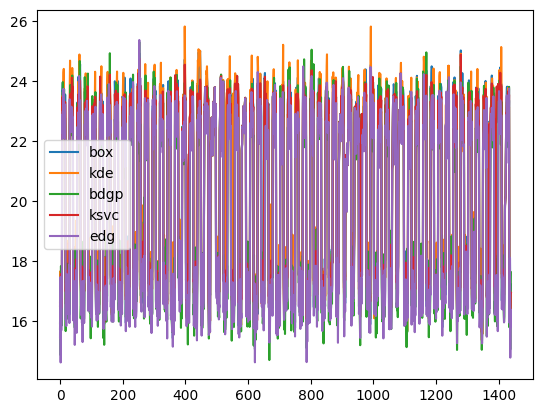

In [101]:
#########################################
#####     new open-loop computation     #####
#########################################

import gurobipy as gp
from gurobipy import GRB
##### indoor temp constraints
day = 100
T_low_base = np.array([15,15,15,15,15,15,15,21,21,21,21,21,21,21,21,21,21,21,15,15,15,15,15,15])
T_low = np.array([T_low_base for _ in range(day)])
T_low = T_low.reshape(-1)

Gx = np.kron(-np.eye(N), np.array([[1,0,0,0]]))

# Gx = np.kron(np.array([[1],[-1]]), np.kron(np.eye(N),np.array([[1,0,0,0]])))

#T_high = 24*np.ones(24*day) 
# gx = np.kron(np.array([T_high, -T_low]), np.ones(N))

##### total input constraints
Gu = np.kron(np.array([[1],[-1]]), np.eye(N))

U_high = 150*np.ones(N)### total maximal power input
gu = np.concatenate((U_high*np.ones(N), np.zeros(N)))


####################### temperature constraints #######################
W1 = Gx@Fu
M1 = Gx@Fw  ### w_vec: vector of disturbance

####################### physical constraints of HP ######################
W2 = Gu
M2 = np.zeros(shape = (2*N, N))
h2 = gu ### gu is the vector constructed from the upper and lower bounds of total inputs

W = np.concatenate((W1,W2), axis = 0)
M = np.concatenate((M1,M2), axis = 0)


b = np.ones(N)

N_sim = 24*60
T_ground = np.mean(T_out)

D_dict = {"box": D_box_set, "kde": D_kde_set, "bdgp": D_set}
d_dict = {"box": d_box_set, "kde": d_kde_set, "bdgp": d_set}

svc_params = np.load(r"svc_param.npz")
sv_points = svc_params["sv_data"]
sv_alpha = svc_params["sv_alpha"]
sv_theta = svc_params["theta"]

multi_rules = False

# name_list = ["box", "kde", "bdgp", "ksvc"]
# name_list = ["kde", "bdgp", "ksvc"]

name_list = ["box", "kde", "bdgp", "ksvc", "edg"]
#name_list = ["ksvc","bdgp","box", "kde", "ksvc"]
x_vec_list = []
for name in name_list:

    if name != "ksvc" and name != "edg":
        D_list = D_dict[name]
        d_list = d_dict[name]
    
    x0 = np.array([22,22,22,22])
    x_vec = x0.copy()
    cost = 0

    L = np.array([])
    g = np.array([])

    time_start = time.time()
    for t in range(N_sim):
    
        v1_vec = T_out[t:t+N]
        v2_vec = T_ground * np.ones(N)
        
        w = np.array([w_simu[t]])
        v = np.array([v1_vec[0], v2_vec[0]])
         
        Fx0 = Fx@x0
    
        #gx = np.concatenate((T_high[t:t+N],-T_low[t:t+N]))
        gx = -T_low[t:t+N]
        h1 = gx - Gx@(Fv1@v1_vec + Fv2@v2_vec + Fx0) ### gx is the upper and lower bounds of indoor temperature

        h = np.concatenate((h1,h2))

        if t%N == 0:
            if name == "edg":
                u, L, g = RMPC_ellip(beta_list, SigmaInv2_list, varrho_list, W, M, h, b, multi_rules = multi_rules)

            elif name == "ksvc":
                u, L, g = MPC_ksvc(sv_points, sv_alpha, sv_theta, W, M, h, b)
            else:
                u, L, g = LDR_RO_oneshot(D_list, d_list, W1, M1, h1, W2, M2, h2, b, multi_rules = multi_rules)
                
            w_vec = w_simu[t:t+N]

        
        else:
            
            #if name != "bdgp" and name != "kde" and name != "edg":
            if name == "ksvc":
                u = np.dot(L[t%N,:].reshape(-1), w_vec) + g[t%N]
                u = np.array([u])

            # elif name == "ksvc":
            #         u = np.array([u])
            
                
            elif name != "edg":
                #for k in range(len(D_list)):
                vio_vec = np.array([np.max(D_list[k]@w_vec - d_list[k]) for k in range(len(D_list))])
                k_min = vio_vec.argmin()
                if multi_rules == False:
                    k_min = 0
                u = np.dot(L[t%N,:,k_min].reshape(-1), w_vec) + g[t%N,k_min]
                u = np.array([u])
            else:
                vio_vec = np.array( [np.linalg.norm(SigmaInv2_list[k]@(w_vec - beta_list[k]), 2) for k in range(len(varrho_list))] )
                
                k_min = vio_vec.argmin()
                if multi_rules == False:
                    k_min = 0
                    
                u = np.dot(L[t%N,:,k_min].reshape(-1), w_vec) + g[t%N,k_min]
                u = np.array([u])


        
                           
        
        cost += u
        x = A@x0 + Bu@u + Bw@w + Bv@v
        x0 = x
        x_vec = np.concatenate((x_vec, x), axis = 0)
        
    time_end = time.time()
    x_vec_list.append(x_vec.reshape(-1,4))

    plt.plot(x_vec.reshape(-1,4)[1:,0])
    plt.legend(name_list)

    vio, vio_per = comp_violation(x_vec.reshape(-1,4)[1:,0], T_low[:N_sim])

    print("open-loop the violation of "+ name + " is: ", vio, vio_per)
    print("open-loop total cost of " + name + " is: ", cost)
    print("open-loop average cost of " + name + " is ", cost/N_sim)
    print("open-loop the average computation time is: ", (time_end - time_start)/N_sim)
    print("\n")
    
    
T_low = np.concatenate((np.array([15]), T_low), axis = 0)

In [ ]:
# min1, max1 = d_min[0] - 2, d_max[0] + 2
# min2, max2 = d_min[1] - 2, d_max[1] + 2
# min3, max3 = d_min[2] - 2, d_max[2] + 2
# min4, max4 = d_min[3] - 2, d_max[3] + 2
# min5, max5 = d_min[4] - 2, d_max[4] + 2
# T = 10


# rang1 = np.linspace(min1, max1, T)
# rang2 = np.linspace(min2, max2, T)
# rang3 = np.linspace(min3, max3, T)
# rang4 = np.linspace(min4, max4, T)
# rang5 = np.linspace(min5, max5, T)

# points_list_box = []
# points_list_ksvc = []

# points_list_kde = [[], []]
# points_list_ellip = [[],[],[],[]]
# points_list_bdgp = [[],[],[],[]]

# K_bdgp = 4
# K_kde = 2
# for i in range(T):
#     for j in range(T):
#         for k in range(T):
#             for m in range(T):
#                 for n in range(T):
#                     point_ary = np.array([rang1[i], rang2[j], rang3[k], rang4[m], rang5[n]])
#                     point = (rang1[i], rang2[j], rang3[k], rang4[m], rang5[n])
                    
#                     if check_inside(D_box_set, d_box_set, point_ary) >= 1:
#                         points_list_box.append(point)

#                     for k in range(K_kde):
#                         if check_inside([D_kde_set[k]], [d_kde_set[k]], point_ary) >= 1:
#                             points_list_kde[k].append(point)

                    
#                     if check_inside_ksvc(multi_alpha, SV_data, point_ary) >= 1:
#                         points_list_ksvc.append(point)
                        
#                     for k in range(K_bdgp):
#                         if check_inside([D_set[k]], [d_set[k]], point_ary) >= 1:
#                             points_list_bdgp[k].append(point)

#                         if check_inside_ellip([beta_list[k]], [SigmaInv2_list[k]], [varrho_list[k]], point_ary) >= 1:
#                             points_list_ellip[k].append(point)
                    
                    

In [ ]:
# shp_box = alphashape.alphashape(points_list_box, alpha = 0.)
# shp_ksvc = alphashape.alphashape(points_list_ksvc, alpha = 0.)

# shp_kde_list = []
# shp_bdgp_list = []
# shp_ellip_list = []
# for k in range(K_kde):
#     shp_kde_list.append(alphashape.alphashape(points_list_kde[k], alpha = 0.))

# for k in range(K_bdgp):
#     shp_bdgp_list.append(alphashape.alphashape(points_list_bdgp[k], alpha = 0.))
#     shp_ellip_list.append(alphashape.alphashape(points_list_ellip[k], alpha = 0.))

In [ ]:
#np.savez("temp_profile.npz", x_vec_list = x_vec_list)
#x_vec_list_load = np.load("temp_profile.npz")["x_vec_list"]

In [ ]:
#x_vec_list_load = np.load("temp_profile.npz")["x_vec_list"]

In [ ]:
# x_vec_list_load[2] = x_vec_list[0]
# x_vec_list_load[4] = x_vec_list[1]
#x_vec_list_load.shape

In [ ]:
# #########################################
# #####     open-loop computation     #####
# #########################################

# import gurobipy as gp
# from gurobipy import GRB
# ##### indoor temp constraints
# day = 100
# T_low_base = np.array([15,15,15,15,15,15,15,21,21,21,21,21,21,21,21,21,21,21,15,15,15,15,15,15])
# T_low = np.array([T_low_base for _ in range(day)])
# T_low = T_low.reshape(-1)

# Gx = np.kron(-np.eye(N), np.array([[1,0,0,0]]))

# # Gx = np.kron(np.array([[1],[-1]]), np.kron(np.eye(N),np.array([[1,0,0,0]])))

# #T_high = 24*np.ones(24*day) 
# # gx = np.kron(np.array([T_high, -T_low]), np.ones(N))

# ##### total input constraints
# Gu = np.kron(np.array([[1],[-1]]), np.eye(N))

# U_high = 150*np.ones(N)### total maximal power input
# gu = np.concatenate((U_high*np.ones(N), np.zeros(N)))


# ####################### temperature constraints #######################
# W1 = Gx@Fu
# M1 = Gx@Fw  ### w_vec: vector of disturbance

# ####################### physical constraints of HP ######################
# W2 = Gu
# M2 = np.zeros(shape = (2*N, N))
# h2 = gu ### gu is the vector constructed from the upper and lower bounds of total inputs

# W = np.concatenate((W1,W2), axis = 0)
# M = np.concatenate((M1,M2), axis = 0)


# b = np.ones(N)

# N_sim = 24*60
# T_ground = np.mean(T_out)

# D_dict = {"box": D_box_set, "kde": D_kde_set, "bdgp": D_set}
# d_dict = {"box": d_box_set, "kde": d_kde_set, "bdgp": d_set}

# svc_params = np.load(r"svc_param.npz")
# sv_points = svc_params["sv_data"]
# sv_alpha = svc_params["sv_alpha"]
# sv_theta = svc_params["theta"]


# # name_list = ["box", "kde", "bdgp", "ksvc"]
# # name_list = ["kde", "bdgp", "ksvc"]

# name_list = ["box", "kde", "bdgp", "ksvc", "edg"]
# #name_list = ["ksvc","bdgp","box", "kde", "ksvc"]
# x_vec_list = []
# for name in name_list:

#     if name != "ksvc" and name != "edg":
#         D_list = D_dict[name]
#         d_list = d_dict[name]
    
#     x0 = np.array([22,22,22,22])
#     x_vec = x0.copy()
#     cost = 0

#     L = np.array([])
#     g = np.array([])

#     time_start = time.time()
#     for t in range(N_sim):
    
#         v1_vec = T_out[t:t+N]
#         v2_vec = T_ground * np.ones(N)
        
#         w = np.array([w_simu[t]])
#         v = np.array([v1_vec[0], v2_vec[0]])
         
#         Fx0 = Fx@x0
    
#         #gx = np.concatenate((T_high[t:t+N],-T_low[t:t+N]))
#         gx = -T_low[t:t+N]
#         h1 = gx - Gx@(Fv1@v1_vec + Fv2@v2_vec + Fx0) ### gx is the upper and lower bounds of indoor temperature

#         h = np.concatenate((h1,h2))

#         if t%N == 0:
#             if name == "edg":
#                 u, L, g = RMPC_ellip(beta_list, SigmaInv2_list, varrho_list, W, M, h, b)

#             elif name == "ksvc":
#                 u, L, g = MPC_ksvc(sv_points, sv_alpha, sv_theta, W, M, h, b)
#             else:
#                 u, L, g = LDR_RO_oneshot(D_list, d_list, W1, M1, h1, W2, M2, h2, b)
                
#             w_vec = w_simu[t:t+N]

        
#         else:
            
#             if name != "bdgp" and name != "kde" and name != "edg":
#                 u = np.dot(L[t%N,:].reshape(-1), w_vec) + g[t%N]

#             elif name == "ksvc":
#                     u = np.array([u])
            
                
#             elif name != "edg":
#                 #for k in range(len(D_list)):
#                 vio_vec = np.array([np.max(D_list[k]@w_vec - d_list[k]) for k in range(len(D_list))])
#                 k_min = vio_vec.argmin()

#                 u = np.dot(L[t%N,:,k_min].reshape(-1), w_vec) + g[t%N,k_min]
#                 u = np.array([u])
#             else:
#                 vio_vec = np.array( [np.linalg.norm(SigmaInv2_list[k]@(w_vec - beta_list[k]), 2) for k in range(len(varrho_list))] )
#                 k_min = vio_vec.argmin()
                
#                 u = np.dot(L[t%N,:,k_min].reshape(-1), w_vec) + g[t%N,k_min]
#                 u = np.array([u])


        
                           
        
#         cost += u
#         x = A@x0 + Bu@u + Bw@w + Bv@v
#         x0 = x
#         x_vec = np.concatenate((x_vec, x), axis = 0)
        
#     time_end = time.time()
#     x_vec_list.append(x_vec.reshape(-1,4))

#     plt.plot(x_vec.reshape(-1,4)[1:,0])
#     plt.legend(name_list)

#     vio, vio_per = comp_violation(x_vec.reshape(-1,4)[1:,0], T_low[:N_sim])

#     print("open-loop the violation of "+ name + " is: ", vio, vio_per)
#     print("open-loop total cost of " + name + " is: ", cost)
#     print("open-loop average cost of " + name + " is ", cost/N_sim)
#     print("open-loop the average computation time is: ", (time_end - time_start)/N_sim)
    
    
# T_low = np.concatenate((np.array([15]), T_low), axis = 0)

In [35]:
x_vec_list_load = x_vec_list

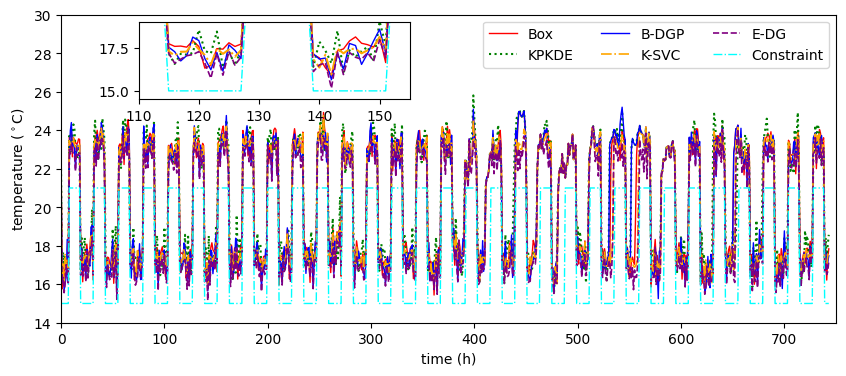

In [38]:
#plt.figure(figsize = (10,4))
xlabel1 = list(range(24*31))
fig, ax = plt.subplots(figsize = (10,4))
ax.plot(xlabel1, x_vec_list_load[0][:,0][:24*31], "-", linewidth = 1, color = "r")
ax.plot(xlabel1, x_vec_list_load[1][:,0][:24*31], linestyle = "dotted", linewidth = 1.5, color = "g")
ax.plot(xlabel1, x_vec_list_load[2][:,0][:24*31], linewidth = 1, color = "b")
ax.plot(xlabel1, x_vec_list_load[3][:,0][:24*31], "-.", linewidth = 1.2, color = "orange")
ax.plot(xlabel1, x_vec_list_load[4][:,0][:24*31], "--", linewidth = 1.2, color = "purple")
ax.plot(xlabel1, T_low[:24*31],"-.", linewidth = 1, color = "cyan")

ax.legend(["Box", "KPKDE", "B-DGP", "K-SVC", "E-DG", "Constraint"], ncols = 3, loc = 1)
ax.axis((0,750,14,30))
ax.set_xlabel("time (h)")
ax.set_ylabel("temperature ($^\circ$C)")

xin1_s = 110
xin1_e = 155
xlabel1_in = list(range(xin1_s,xin1_e))
axin = ax.inset_axes((0.1,0.725, 0.35,0.25))
axin.plot(xlabel1_in, x_vec_list_load[0][:,0][xlabel1_in], "-", linewidth = 1, color = "r")
axin.plot(xlabel1_in, x_vec_list_load[1][:,0][xlabel1_in], linestyle = "dotted", linewidth = 1.5, color = "g")
axin.plot(xlabel1_in, x_vec_list_load[2][:,0][xlabel1_in], linewidth = 1, color = "b")
axin.plot(xlabel1_in, x_vec_list_load[3][:,0][xlabel1_in], "-.", linewidth = 1.5, color = "orange")
axin.plot(xlabel1_in, x_vec_list_load[4][:,0][xlabel1_in], "--", linewidth = 1.2, color = "purple")
axin.plot(xlabel1_in, T_low[xlabel1_in], "-.", linewidth = 1, color = "cyan")
axin.axis((xin1_s,xin1_e,14.5,19))

plt.savefig("mpc_temp1.pdf", bbox_inches = "tight" )

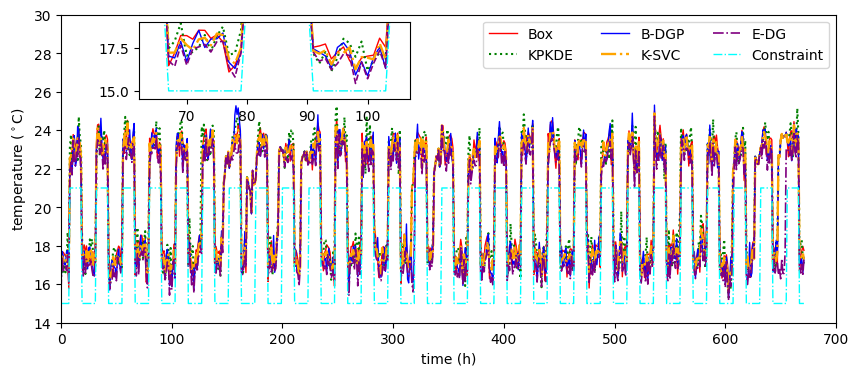

In [39]:
#plt.figure(figsize = (10,3))
fig, ax2 = plt.subplots(figsize = (10,4))
xlabel2 = list(range(24*28))
ax2.plot(xlabel2, x_vec_list_load[0][:,0][24*31:24*59], "-", linewidth = 1, color = "r")
ax2.plot(xlabel2, x_vec_list_load[1][:,0][24*31:24*59], linestyle = "dotted", linewidth = 1.5, color = "green")
ax2.plot(xlabel2, x_vec_list_load[2][:,0][24*31:24*59], linewidth = 1, color = "b")
ax2.plot(xlabel2, x_vec_list_load[3][:,0][24*31:24*59], "-.", linewidth = 1.7, color = "orange")
ax2.plot(xlabel2, x_vec_list_load[4][:,0][24*31:24*59], "-.", linewidth = 1.2, color = "purple")
ax2.plot(xlabel2, T_low[24*31:24*59],"-.", linewidth = 1, color = "cyan")
ax2.legend(["Box", "KPKDE", "B-DGP", "K-SVC", "E-DG", "Constraint"], ncols = 3, loc = 1)
ax2.axis((0,700,14,30))
ax2.set_xlabel("time (h)")
ax2.set_ylabel("temperature ($^\circ$C)")
#plt.savefig("open_mpc_temp2.pdf", bbox_inches = "tight" )
xin2_s = 62
xin2_e = xin2_s + 45
xlabel2_in_x = list(range(xin2_s, xin2_e))
xlabel2_in = list(range(xin2_s + 24*31, xin2_e + 24*31))

axin2 = ax2.inset_axes((0.1,0.725, 0.35,0.25))
axin2.plot(xlabel2_in_x, x_vec_list_load[0][:,0][xlabel2_in], "-", linewidth = 1, color = "r")
axin2.plot(xlabel2_in_x, x_vec_list_load[1][:,0][xlabel2_in], linestyle = "dotted", linewidth = 1.5, color = "g")
axin2.plot(xlabel2_in_x, x_vec_list_load[2][:,0][xlabel2_in], linewidth = 1, color = "b")
axin2.plot(xlabel2_in_x, x_vec_list_load[3][:,0][xlabel2_in], "-.", linewidth = 1.7, color = "orange")
axin2.plot(xlabel2_in_x, x_vec_list_load[4][:,0][xlabel2_in], "--", linewidth = 1.2, color = "purple")
axin2.plot(xlabel2_in_x, T_low[xlabel2_in], "-.", linewidth = 1, color = "cyan")
axin2.axis((xin2_s, xin2_e, 14.5,19))

plt.savefig("mpc_temp2.pdf", bbox_inches = "tight" )

In [ ]:
# svc_params = np.load(r"svc_param.npz")
# sv_points = svc_params["sv_data"]
# sv_alpha = svc_params["sv_alpha"]
# sv_theta = svc_params["theta"]
#MPC_ksvc(sv_points, sv_alpha, theta, W, M, h, b)

In [ ]:
# day = 50
# T_low_base = np.array([15,15,15,15,15,15,15,21,21,21,21,21,21,21,21,21,21,21,15,15,15,15,15,15])
# T_low = np.array([T_low_base for _ in range(day)])
# T_low = T_low.reshape(-1)

# Gx = np.kron(-np.eye(N), np.array([[1,0,0,0]]))

# #Gx = np.kron(np.array([[1],[-1]]), np.kron(np.eye(N),np.array([[1,0,0,0]])))

# T_high = 24*np.ones(24*day) 
# # gx = np.kron(np.array([T_high, -T_low]), np.ones(N))

# ##### total input constraints
# Gu = np.kron(np.array([[1],[-1]]), np.eye(N))

# U_high = 150*np.ones(N)### total maximal power input
# gu = np.concatenate((U_high*np.ones(N), np.zeros(N)))


# ####################### temperature constraints #######################
# W1 = Gx@Fu
# M1 = Gx@Fw  ### w_vec: vector of disturbance

# ####################### physical constraints of HP ######################
# W2 = Gu
# M2 = np.zeros(shape = (2*N, N))
# h2 = gu ### gu is the vector constructed from the upper and lower bounds of total inputs

# W = np.concatenate((W1,W2), axis = 0)
# M = np.concatenate((M1,M2), axis = 0)


# b = np.ones(N)

# N_sim = 24*1
# T_ground = np.mean(T_out)

# cost = 0
# x0 = 22*np.ones(4)
# x_vec = x0.copy()

# for t in range(N_sim):

#     v1_vec = T_out[t:t+N]
#     v2_vec = T_ground * np.ones(N)

#     v1_vec = T_out[t:t+N]
#     v2_vec = T_ground * np.ones(N)
    
#     w = np.array([w_simu[t]])
#     v = np.array([v1_vec[0], v2_vec[0]])
    
#     x0 = 22*np.ones(4)
     
#     Fx0 = Fx@x0
    
#     gx = -T_low[t:t+N]
#     h1 = gx - Gx@(Fv1@v1_vec + Fv2@v2_vec + Fx0)
    
#     h = np.concatenate((h1,h2))

#     u = MPC_ksvc(sv_points, sv_alpha, theta, W, M, h, b)

#     cost += u
#     x = A@x0 + Bu@u + Bw@w + Bv@v
#     x0 = x
#     x_vec = np.concatenate((x_vec, x), axis = 0)

# plt.plot(x_vec.reshape(-1,4)[1:,0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Mean and covariance
mean = np.array([1, 2, 3])
covariance = np.array([[1020, 0, 0], [0, 2, 0], [0, 0, 6]])

# Eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(covariance)

# Create a grid of points
theta = np.linspace(0, 2*np.pi, 100)
phi = np.linspace(0, np.pi, 100)
theta, phi = np.meshgrid(theta, phi)
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

# Scale by the square roots of the eigenvalues
for i in range(3):
    x *= np.sqrt(eigenvalues[i])
    y *= np.sqrt(eigenvalues[i])
    z *= np.sqrt(eigenvalues[i])

# Rotate by eigenvectors and translate by mean
ellipsoid = np.dot(eigenvectors, np.array([x, y, z]).reshape(3, -1))
ellipsoid += mean[:, np.newaxis]

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(ellipsoid[0].reshape(100, 100), ellipsoid[1].reshape(100, 100), ellipsoid[2].reshape(100, 100), color='b')
plt.show()


In [ ]:
RMPC_ellip(beta_list, SigmaInv2_list, varrho_list, W, M, h, b)